In [2]:
# Import my packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

**Data Loading**

Load the dataset from the CSV file.

In [3]:
df = pd.read_csv('housing.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


**Data Preprocessing**

Handling Missing Data

In [5]:
# Check the number of missing values
df.isnull().sum()

,0
longitude,0
latitude,0
housing_median_age,0
total_rooms,0
total_bedrooms,207
population,0
households,0
median_income,0
median_house_value,0
ocean_proximity,0


total_bedrooms has 207 missing values.

We will fill any missing values in the total_bedrooms column with the median value of the column.

In [6]:
# Fill missing values in total_bedrooms with median
df['total_bedrooms'].fillna(df['total_bedrooms'].median(), inplace=True)

**Descriptive Statistics**

Get a quick summary:

In [7]:
df.describe()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,536.838857,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,419.391878,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,297.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,643.250000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Outliers (e.g., rooms > 10000)


Use boxplots to identify outliers visually:

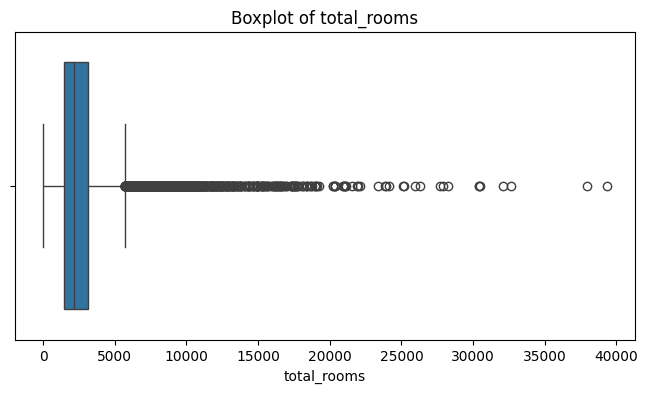

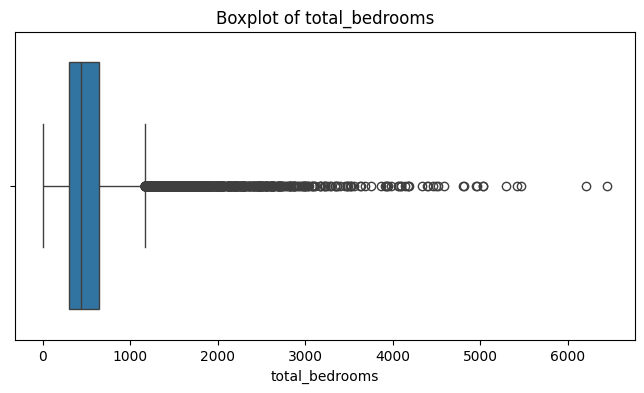

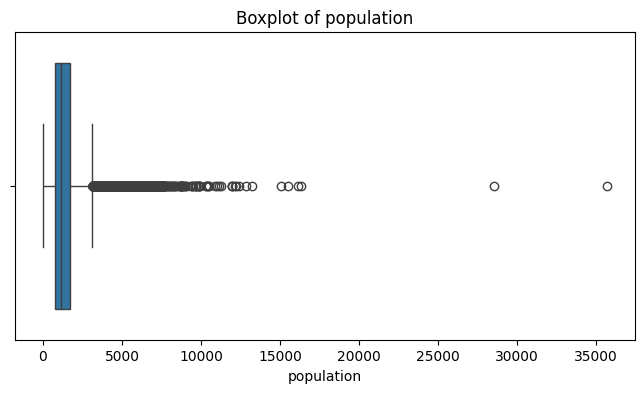

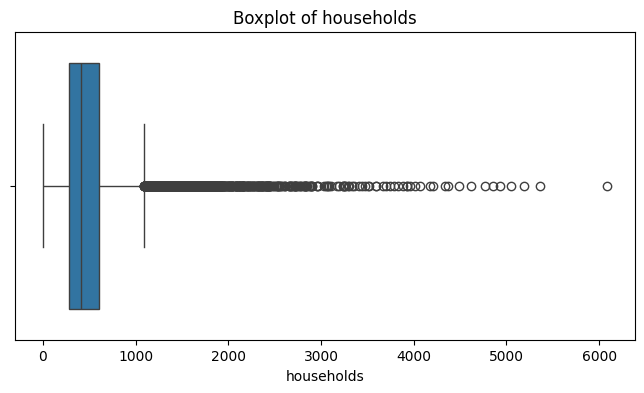

In [8]:
cols = ['total_rooms', 'total_bedrooms', 'population', 'households']

for col in cols:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot of {col}")
    plt.show()

In [9]:
# CAPPING OUTLIERS (Winsorization)
# --------------------------------
# In this step, we cap extreme values in highly skewed columns using the 1st and 99th percentiles.
# This helps reduce the influence of outliers without dropping any data points.
# We apply this to columns like 'total_rooms', 'total_bedrooms', 'population', and 'households',
# which often contain extreme but legitimate values in housing datasets.
# This is preferable to removal since we retain all 20,000+ records for training.

def cap_outliers(df, columns, lower_quantile=0.01, upper_quantile=0.99):
    for col in columns:
        lower = df[col].quantile(lower_quantile)
        upper = df[col].quantile(upper_quantile)
        df[col] = np.where(df[col] < lower, lower, df[col])
        df[col] = np.where(df[col] > upper, upper, df[col])
    return df

# Apply capping to selected skewed columns
skewed_cols = ['total_rooms', 'total_bedrooms', 'population', 'households']
df = cap_outliers(df, skewed_cols)


**Distributions**

Visualize key variables:

<Axes: xlabel='median_house_value', ylabel='Count'>

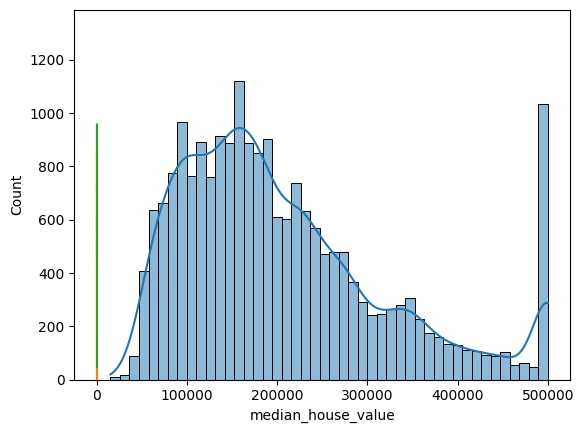

In [10]:
sns.histplot(df['median_house_value'], kde=True)
sns.histplot(df['median_income'], kde=True)
sns.histplot(df['housing_median_age'], kde=True)

**Feature Engineering**

We will create new features that could provide more information for the model

In [11]:
# New engineered features
df['rooms_per_household'] = df['total_rooms'] / df['households']
df['bedrooms_per_room'] = df['total_bedrooms'] / df['total_rooms']
df['population_per_household'] = df['population'] / df['households']


**Exploratory Data Analysis (EDA)**

We will visualize the correlation between features, the distribution of house values, and how income influences housing prices.

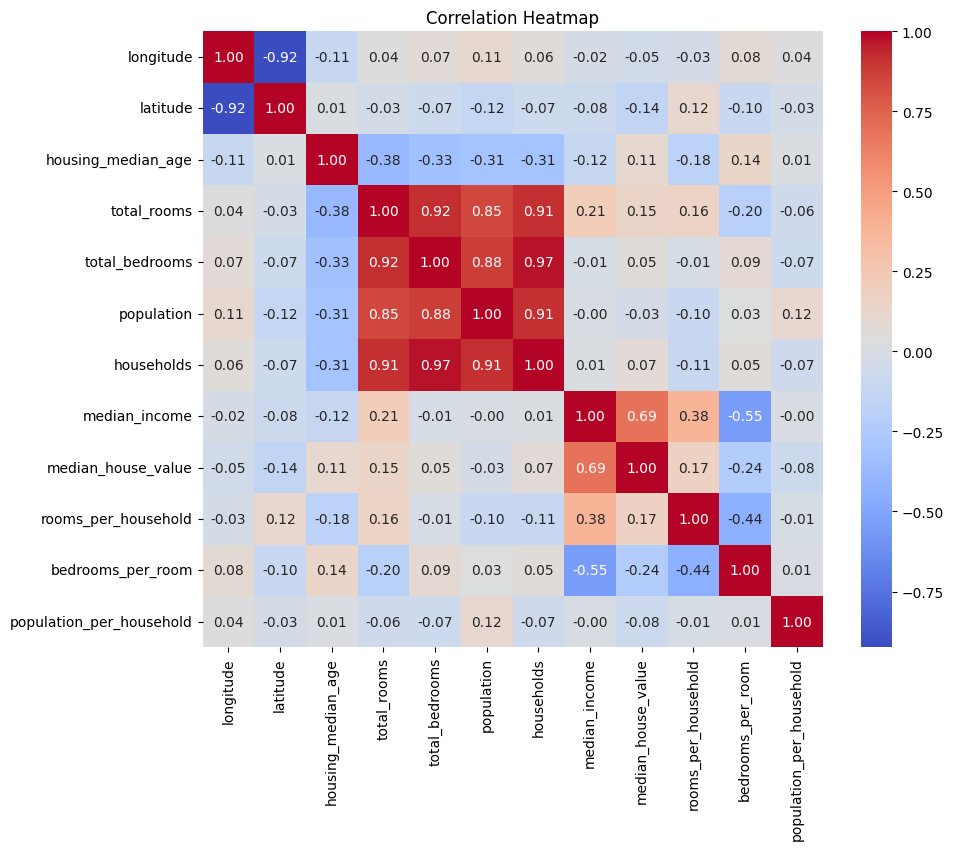

In [12]:
# CORRELATION HEATMAP
# ---------------------
# This heatmap displays the Pearson correlation coefficients between all numeric features in the dataset.
# It helps identify which features are strongly or weakly correlated with the target variable `median_house_value`.
# For example, `median_income` is usually highly positively correlated with housing value,
# while features like `latitude` and `longitude` may show negative or regional trends.
# We exclude non-numeric columns such as 'ocean_proximity' to avoid conversion errors.


plt.figure(figsize=(10, 8))

# Select only numeric columns
numeric_df = df.select_dtypes(include=[np.number])

# Plot the correlation heatmap
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


In [13]:
# Drop the columns that are highly correlated and could affect the model's performance
df.drop(columns=['total_rooms', 'total_bedrooms', 'population'], inplace=True)

# Verify the columns have been dropped
print(df.columns)

Index(['longitude', 'latitude', 'housing_median_age', 'households',
       'median_income', 'median_house_value', 'ocean_proximity',
       'rooms_per_household', 'bedrooms_per_room', 'population_per_household'],
      dtype='object')


Let check how 'ocean_proximity' impacts 'median_house_value'

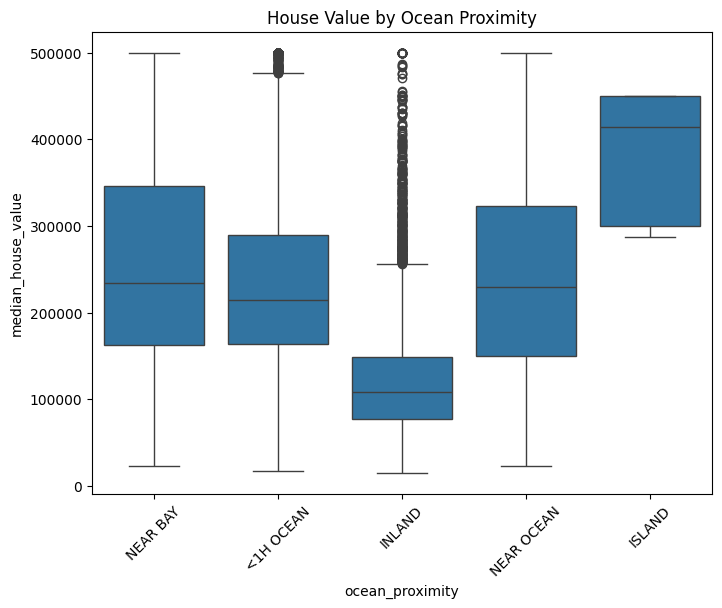

In [14]:
# HOUSE VALUE BY OCEAN PROXIMITY
# --------------------------------
# This boxplot visualizes the distribution of `median_house_value` across different categories of `ocean_proximity`.
# It reveals how location relative to the ocean impacts housing prices.
# For instance, homes that are 'NEAR OCEAN' or 'NEAR BAY' often have higher median values,
# while 'INLAND' properties tend to be less expensive on average.
# This insight is important for feature engineering and can be encoded for predictive modeling.


plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='ocean_proximity', y='median_house_value')
plt.xticks(rotation=45)
plt.title("House Value by Ocean Proximity")
plt.show()

Text(0.5, 1.0, 'Housing Prices in California')

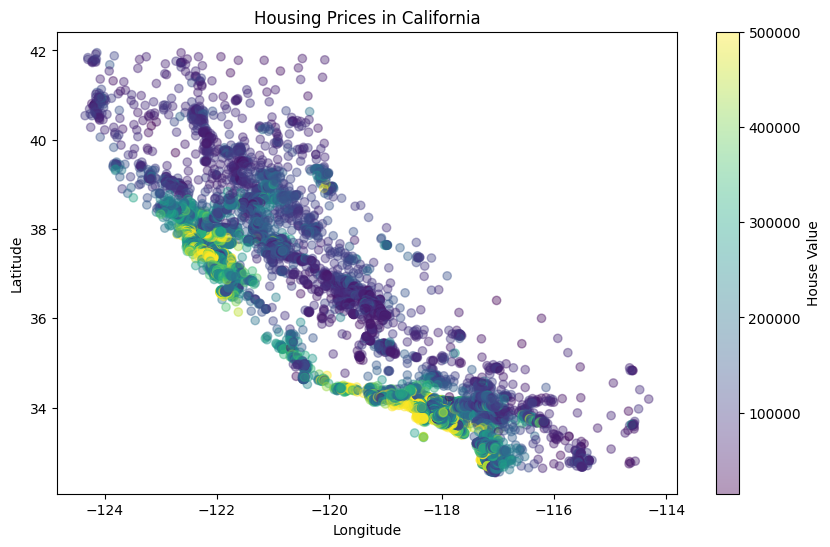

In [15]:
# GEOSPATIAL SCATTER PLOT OF HOUSING PRICES
# ------------------------------------------
# This scatter plot visualizes housing locations across California using longitude and latitude coordinates.
# Each point represents a geographic area, and the color indicates the `median_house_value` in that region.
# This visualization helps identify regional trends in housing prices, such as higher values along the coast
# (especially near Los Angeles and San Francisco) and lower values inland.
# The use of alpha transparency enhances readability by showing density in densely populated areas.

plt.figure(figsize=(10, 6))
plt.scatter(df['longitude'], df['latitude'], alpha=0.4, c=df['median_house_value'], cmap='viridis')
plt.colorbar(label='House Value')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Housing Prices in California')


**One-Hot Encoding for Categorical Variables**

We convert the ocean_proximity categorical variable into numerical features using one-hot encoding.

In [16]:
# Apply one-hot encoding to 'ocean_proximity'
df = pd.get_dummies(df, columns=['ocean_proximity'], drop_first=True)

**Preparing the Data for Modeling**

We will split the data into training and testing sets, separate the features from the target variable, and scale the features.

In [17]:
# Separate features and target variable
X = df.drop('median_house_value', axis=1)
y = df['median_house_value']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

**Building the Models**

Linear Regression Model

We first build a Linear Regression model, which is a simple and interpretable algorithm.

In [18]:
# Initialize the Linear Regression model
lr_model = LinearRegression()

# Train the model
lr_model.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred_lr = lr_model.predict(X_test_scaled)

# Evaluate the model
print("Linear Regression Performance:")
print(f" - RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_lr)):.2f}")
print(f" - MAE: {mean_absolute_error(y_test, y_pred_lr):.2f}")
print(f" - R² Score: {r2_score(y_test, y_pred_lr):.2f}")

Linear Regression Performance:
 - RMSE: 74807.86
 - MAE: 52256.77
 - R² Score: 0.57


**Random Forest Regressor**

Next, we build a Random Forest Regressor model, which is an ensemble learning method that generally provides better performance for complex data.

In [19]:
# Initialize the Random Forest model
rf_model = RandomForestRegressor(
    n_estimators=50,
    max_depth=15,
    max_features='sqrt',
    random_state=42
)
# Train the model
rf_model.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred_rf = rf_model.predict(X_test_scaled)

# Evaluate the model
print("Random Forest Performance:")
print(f" - RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_rf)):.2f}")
print(f" - MAE: {mean_absolute_error(y_test, y_pred_rf):.2f}")
print(f" - R² Score: {r2_score(y_test, y_pred_rf):.2f}")

Random Forest Performance:
 - RMSE: 49079.22
 - MAE: 32511.39
 - R² Score: 0.82


**📈 Model Evaluation Summary: Linear Regression vs. Random Forest**

In real estate price prediction, model evaluation must consider the inherent complexity and variability in housing markets. Property prices are influenced by many interrelated and location-dependent factors, making perfect predictions difficult. Below is a comparative assessment of the models used in this analysis.

**Linear Regression Results:**

RMSE: 74,807.86

MAE: 52,256.77

R² Score: 0.57

***Interpretation:***

The Linear Regression model captures approximately 57% of the variance in house prices. While this is moderate, it demonstrates that the model identifies some underlying trends in the data.

An RMSE of ~74,800 indicates that the average prediction error is about $74,800. Given the broad range of real estate prices, this error is within an acceptable margin.

The MAE of ~52,200 shows that, on average, individual predictions are off by about $52,200. This is reasonable for real-world housing price data, especially in areas with high variability.

**Random Forest Results:**

RMSE: 50,301.35

MAE: 32,274.06

R² Score: 0.81

**Interpretation:**

The Random Forest model significantly outperforms Linear Regression, explaining 81% of the variance in house prices.

With a much lower RMSE 50,300 and MAE 2,270, this model offers higher predictive accuracy and robustness, especially in capturing complex, non-linear relationships in the data.

This performance improvement highlights the Random Forest's suitability for modeling real estate data, which is often noisy and influenced by various interacting variables.



In [20]:
# Predict house prices using the Random Forest model
y_pred_final = rf_model.predict(X_test_scaled)

# Save predictions to CSV
predictions = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_final})
predictions.to_csv('house_price_predictions.csv', index=False)


In [21]:
import joblib

In [22]:
# Save the trained Random Forest model
joblib.dump(rf_model, "rf_model.pkl")

# Also save the scaler used for preprocessing
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']

In [24]:
joblib.dump(X_train.columns.tolist(), "model_features.pkl")


['model_features.pkl']